# Load modules

In [155]:
import numpy as np
import pandas as pd
import xgboost as xgb
    
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV

# Load data

In [140]:
data = np.load(os.path.join('data', 'dataset_smile_challenge.npy'), allow_pickle = True).item()

#training dataset 
train = data['train']

deep_features_train = train['deep_features'] # for deep features.
deep_features_train['ECG_features_C'] # conv1d backbone based features for ECG signal.
deep_features_train['ECG_features_T'] # transformer backbone based features for ECG signal   
handcrafted_features_train = train['hand_crafted_features'] # for hand-crafted features.

#test dataset
test = data['test']

deep_features_test = test['deep_features'] # for deep features {'ECG_features_C', 'ECG_features_T'}.
handcrafted_features_test = test['hand_crafted_features'] # for hand-crafted features {'ECG_features', 'GSR_features'}.

# extracting labels and converting labels >= 1 to just 1.
y_train = train['labels']
th = 1
y_train[y_train<th] = 0
y_train[y_train>0] = 1



# Analyze dataset

<AxesSubplot:>

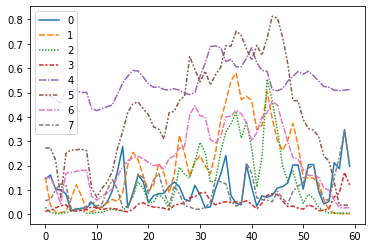

In [160]:
#Visualize a data sample
sns.lineplot(data=handcrafted_features_train['ECG_features'][0])

In [169]:
print('Prevalence of CLASS = 0: ' + str(100*np.sum(y_train)/y_train.shape[0]) + '%')
print('Prevalence of CLASS = 1: ' + str(100*(y_train.shape[0]-np.sum(y_train))/y_train.shape[0]) + '%')

Prevalence of CLASS = 0: 52.7536231884058%
Prevalence of CLASS = 1: 47.2463768115942%


# Feature extraction

In [146]:
x_train = []
for hftg in handcrafted_features_train['GSR_features']:
    x_train.append(np.concatenate((np.nanmean(hftg,axis=0),np.nanstd(hftg,axis=0)),axis=0))
x_train = np.array(x_train)
x_test = []
for hftg in handcrafted_features_test['GSR_features']:
    x_test.append(np.concatenate((np.nanmean(hftg,axis=0),np.nanstd(hftg,axis=0)),axis=0))
x_test = np.array(x_test)

<AxesSubplot:>

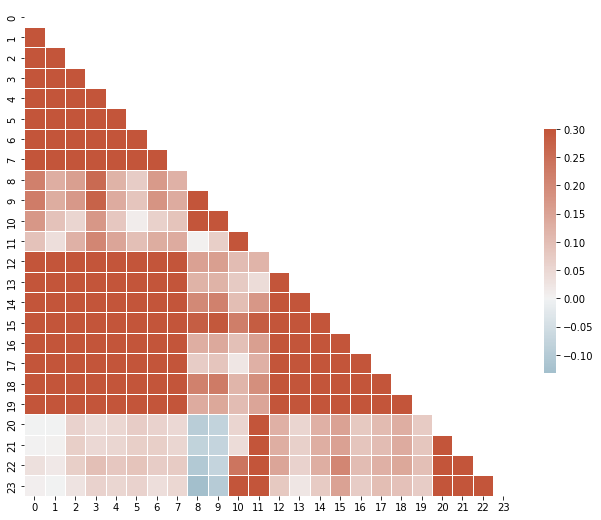

In [157]:
d = pd.DataFrame(data=x_test)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Model building

In [158]:
clf = xgb.XGBClassifier()
xgb_params = {
'learning_rate': [0.01, 0.1],
'n_estimators': [2000],
'max_depth': [3, 5, 7, 9],
'gamma': [0, 1],
'subsample': [0.7, 1],
'colsample_bytree': [0.7, 1]
}

clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# Make and save predictions

In [148]:
y_hat_test = clf.predict(x_test)
np.savetxt(os.path.join('submission', 'answer.txt'),y_hat_test.astype(int),fmt='%1d')